In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft
import astropy.units as u
from astropy.visualization import quantity_support

In [2]:
# %matplotlib notebook
# %reload_ext autoreload
# %autoreload 2

quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x247130d8df0>

Start by defining the MOXSI aperture (pinhole)

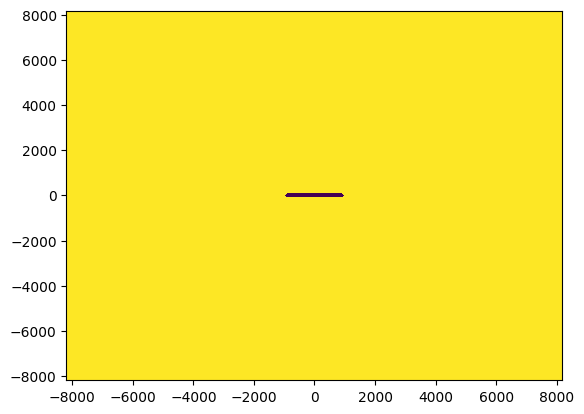

In [3]:


pinhole_diameter = 44
center2center_distance = 440


x_oversample = 4

x = np.arange(4096*x_oversample)
x = x - x.shape[0]//2


y = x.copy()

shp_x = x.shape[0]
x = x[...,None]
y = y[None,...]

x = np.broadcast_to(x,(shp_x,shp_x))
y = np.broadcast_to(y,(shp_x,shp_x))


#shift coordinate system
x_shift = x-center2center_distance/2 * x_oversample

r = np.sqrt(x_shift*x_shift + y*y)
pinhole = np.ones_like(r)
pinhole[r<pinhole_diameter/2 * x_oversample] = 0

#shift coordinate system
x_shift = x+center2center_distance/2 * x_oversample

r = np.sqrt(x_shift*x_shift + y*y)
pinhole2 = np.ones_like(r)
pinhole2[r<pinhole_diameter/2 * x_oversample] = 0


x_cut = np.ones_like(r)
y_cut = np.ones_like(r)

x_cut *= x > -center2center_distance / 2 * x_oversample
x_cut *= x < center2center_distance / 2 * x_oversample

y_cut *= y > -pinhole_diameter/2 * x_oversample
y_cut *= y < pinhole_diameter/2 * x_oversample

rectangle = x_cut * y_cut
rectangle = 0**rectangle

aperture_shape = pinhole * pinhole2 * rectangle
# aperture = rectangle
fig, ax = plt.subplots()
ax.pcolormesh(x, y, aperture_shape)


In [4]:
# wv = 10*u.AA
# f = 19*u.cm
#
# aperture = shp_x * u.micron
#
#
#
# f_number = f/aperture
#
# fresnel_zone = np.sqrt(wv*f).to(u.micron)
# print('First Fresnel Zone Diameter', fresnel_zone*2)
#
# oversample = 4
#
# dx = wv * f_number / oversample
# dx = dx.to(u.micron)
#
#|
# wfe = pinhole * 1e9 * 1j

def wfe2psf(wfe,oversample):
    shp = wfe.shape[0]
    waves = np.exp(2*np.pi*wfe*1j)

    big_waves = np.zeros((shp*oversample,shp*oversample),dtype='complex')
    big_waves[0:shp,0:shp] = waves

    psf = scipy.fft.fft2(big_waves, workers=-1)
    psf = np.abs(psf)**2
    psf /= psf.max()

    psf = np.roll(psf,(shp//2,shp//2),axis=[0,1])
    psf = psf[0:shp,0:shp]

    return psf

# print(psf.shape)
# fig,ax = plt.subplots()
# ax.plot(x[:,shp_x//2]*dx,psf[:,shp_x//2])

Add Fresnel Phase Factor

In [5]:
f = 19.5*u.cm
pixel_pitch = 7*u.micron/u.pixel

spatial_plate_scale = (pixel_pitch/f).to(1/u.pixel)*u.radian
spatial_plate_scale = spatial_plate_scale.to(u.arcsec/u.pixel)
print(spatial_plate_scale)

aperture_extent = (shp_x / x_oversample) * u.micron
f_number = f/aperture_extent
print(f_number.to(u.micron/u.micron))

7.404377660152177 arcsec / pix
47.607421875


In [ ]:

fig, ax = plt.subplots()


wvs = [5*u.AA, 10*u.AA, 25*u.AA, 50*u.AA]
ovs = [2,1,1,1]

wvs = [10*u.AA, 20*u.AA]
ovs = [1,1]

# wvs = [10*u.AA]
# ovs = [1]

psfs = []
xs = []
for wv,oversample in zip(wvs,ovs):

    fresnel_zone = np.sqrt(wv*f).to(u.micron)
    print('First Fresnel Zone Diameter', fresnel_zone*2)

    # oversample = 4  #computes aperture FFT on a different grid to properly resolve the PSF


    wfe = aperture_shape * 1e9 * 1j

    dx = wv * f_number / oversample

    print(dx)
    dx = dx.to(u.micron)
    print(dx)
    dx = dx/pixel_pitch*spatial_plate_scale



    fresnel_wfe = 1/(2*wv*f)*((x*x+y*y)/x_oversample**2) * u.micron**2 + 0.j
    fresnel_wfe = fresnel_wfe.value
    wfe_total = wfe+fresnel_wfe

    # psf = wfe2psf(wfe,oversample)
    fresnel_psf = wfe2psf(wfe_total,oversample)
    fig_2, ax_2 =plt.subplots()
    ax_2.pcolormesh(x*dx,y*dx, fresnel_psf)


    print(x.shape)
    print(fresnel_psf.shape)
    x_1D = x[:, shp_x // 2] * dx
    psf_1D = fresnel_psf[:, shp_x // 2]
    ax.plot(x_1D, psf_1D, label=wv)
    psfs.append(psf_1D)
    xs.append(x_1D)

pin = pinhole_diameter*u.micron / pixel_pitch*spatial_plate_scale / 2
ax.vlines([-pin,pin],[0,0],[1,1],color = 'black', label='pinhole')

ax.set_xlim([-300*u.arcsec, 300*u.arcsec])
ax.legend()
ax.set_title('PSF for f ='+str(f)+' and d='+str(pinhole_diameter*u.micron))


    # ax.plot(x[:,shp_x//2]*dx,psf[:,shp_x//2])


First Fresnel Zone Diameter 27.92848008753789 micron
0.047607421875 Angstrom cm / micron
0.047607421875000014 micron
(16384, 16384)
(16384, 16384)
First Fresnel Zone Diameter 39.496835316263 micron
0.09521484375 Angstrom cm / micron
0.09521484375000003 micron


In [ ]:
import scipy.interpolate


new_x = np.linspace(-75,75,301) * u.arcsec

fig,ax = plt.subplots()
new_psfs = []
for psf, x  in zip(psfs,xs):
    func = scipy.interpolate.interp1d(x = x, y = psf)
    new_psf = func(new_x)
    new_psfs.append(new_psf)
    ax.plot(new_x,new_psf)

ax.vlines([-pin,pin],[0,0],[1,1],color = 'black', label='pinhole')

ax.set_xlim([-50*u.arcsec, 50*u.arcsec])
ax.legend()
ax.set_title('PSF for f ='+str(f)+' and d='+str(pinhole_diameter*u.micron))



In [ ]:
sigma = 7 * u.arcsec
PV = 30 * u.arcsec
jitter_gaussian = np.exp(-new_x**2/(2*sigma**2))
jitter_rect = np.ones_like(new_x)
jitter_rect[new_x > PV/2] = 0
jitter_rect[new_x < -PV/2] = 0

fig,ax = plt.subplots()
ax.plot(new_x,jitter_gaussian)
ax.plot(new_x,jitter_rect.value)

In [ ]:
fig, ax = plt.subplots()
for psf in new_psfs:
    rect_psf = np.convolve(psf,jitter_rect,mode='same')
    rect_psf /= rect_psf.sum()
    ax.plot(new_x,rect_psf)
    print('FWHM = ' +str(2*np.abs(new_x[np.argmin(np.abs(rect_psf-rect_psf.max()*.5))])))



In [ ]:
fig, ax = plt.subplots()
for psf in new_psfs:
    gauss_psf = np.convolve(psf,jitter_gaussian,mode='same')
    gauss_psf /= gauss_psf.sum()
    ax.plot(new_x,gauss_psf)
    print('FWHM = ' +str(2*np.abs(new_x[np.argmin(np.abs(gauss_psf-gauss_psf.max()*.5))])))
